## Libraries

In [1]:
import pandas as pd
import numpy as np
from itertools import chain
import os.path

# Hi-C utilities imports:
import cooler
import bioframe
import cooltools
from cooltools.lib.numutils import fill_diag
from packaging import version
import bbi

from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup

import itertools

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 600
import seaborn as sns

from itertools import combinations

/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:651: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)
/home/carlos/miniconda3/envs/gnn/lib/python3.11/site-packages/cooltools/lib/numutils.py:726: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit  # (nopython=True)


## Data Prep

In [2]:
resolution = 10_000
nproc = 8
tolerance = 10_000
use_round_kernels = False
cluster_filtering = True
samples = ["t0", "t12", "t30", "t60"]

In [3]:
clrs_ = [
    cooler.Cooler(
        f"/home/carlos/Desktop/manuscripts/notebooks/matrices/{sample}_q30.mcool::resolutions/10000"
    )
    for sample in samples
]

In [4]:
hg38_chromsizes = bioframe.fetch_chromsizes("hg38")
hg38_cens = bioframe.fetch_centromeres("hg38")
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)
hg38_arms = hg38_arms.set_index("chrom").loc[clrs_[0].chromnames].reset_index()


if not os.path.exists(f"expected_t0.{resolution}.csv"):
    # intra-arm expected
    expected_ = [
        cooltools.expected_cis(
            clr,
            view_df=hg38_arms,
            nproc=nproc,
        )
        for clr in clrs_
    ]

    for sample, exp_df in zip(samples, expected_):
        exp_df.to_csv(f"expected_{sample}.{resolution}.csv", index=False)
else:
    expected_ = [
        pd.read_csv(f"expected_{sample}.{resolution}.csv")
        for sample in samples
    ]

In [5]:
kernels_main = cooltools.api.dotfinder.recommend_kernels(resolution)

if use_round_kernels:
    half = 5
    x, y = np.meshgrid(
        np.linspace(-half, half, 2*half + 1),
        np.linspace(-half, half, 2*half + 1),
    )
    mask = (x**2+y**2 > 7) & (x**2+y**2 <= 30)
    mask[:,half] = 0
    mask[half,:] = 0

    mask_ll = mask.copy()
    mask_ll[:,:half] = 0
    mask_ll[half:,:] = 0

    kernels = {'donut': mask,
    'vertical': kernels_main["vertical"].copy(),
    'horizontal': kernels_main["horizontal"].copy(),
    'lowleft': mask_ll}
else:
    kernels = kernels_main

if not os.path.exists(f"t0_cf{cluster_filtering}_roundKernels{use_round_kernels}_dots.tsv"):
    print(f"Using round kernels: {use_round_kernels}")
    print(f"Cluster filtering: {cluster_filtering}")
    dots_df_ = [
        cooltools.dots(
            clr,
            expected=expected,
            view_df=hg38_arms,
            max_loci_separation=10_000_000,
            nproc=nproc,
            cluster_filtering=True,
            kernels = kernels,
        ) for clr, expected in zip(clrs_, expected_)
        ]
    for df, sample in zip(dots_df_, samples):
            df.to_csv(f"{sample}_cf{cluster_filtering}_roundKernels{use_round_kernels}_dots.tsv", index=False, sep="\t")
else:
    print(f"Using round kernels: {use_round_kernels}")
    print(f"Cluster filtering: {cluster_filtering}")
    dots_df_ = [
        pd.read_csv(f"{sample}_cf{cluster_filtering}_roundKernels{use_round_kernels}_dots.tsv", sep="\t")
        for sample in samples
    ]

INFO:root:Using recommended donut-based kernels with w=5, p=2 for binsize=10000


Using round kernels: False
Cluster filtering: True


## Dots Ops

In [6]:
def prepare_merged_anchor(dots_df_, min_dist=50_000):
    loops_df_list = [df.iloc[:, :6] for df in dots_df_]
    all_dots = pd.concat(loops_df_list).drop_duplicates()
    anchors1 = all_dots.iloc[:, :3]
    anchors2 = all_dots.iloc[:, 3:6]
    anchors1.columns = ["chrom", "start", "end"]
    anchors2.columns = ["chrom", "start", "end"]
    all_anchors = pd.concat([anchors1, anchors2]).drop_duplicates().reset_index(drop=True)
    all_anchors = bioframe.merge(all_anchors, min_dist=min_dist)
    return all_anchors, loops_df_list

def overlap_to_all_anchors(loops_df_list, all_anchors):
    for i, df in enumerate(loops_df_list):
        anchors1 = df.iloc[:, :3]
        anchors2 = df.iloc[:, 3:6]
        anchors1.columns = ["chrom", "start", "end"]
        anchors2.columns = ["chrom", "start", "end"]

        overlap1 = bioframe.overlap(anchors1, all_anchors, return_index=True)
        overlap2 = bioframe.overlap(anchors2, all_anchors, return_index=True)

        loops_df_list[i].loc[:, "anchor1"] = overlap1.loc[:, "index_"]
        loops_df_list[i].loc[:, "anchor2"] = overlap2.loc[:, "index_"]

        loops_df_list[i].sort_values(["anchor1", "anchor2"], inplace=True)
        loops_df_list[i].drop_duplicates(subset=["anchor1", "anchor2"], inplace=True)

    return loops_df_list

In [7]:
min_dist = 50_000

all_anchors, loops_df_list = prepare_merged_anchor(dots_df_= dots_df_, min_dist = min_dist)
loops_df_list = overlap_to_all_anchors(loops_df_list, all_anchors)
all_anchors.groupby("n_intervals").size()

n_intervals
1     5408
2     2611
3     1206
4      545
5      211
6       84
7       62
8       15
9        7
10       5
11       3
13       3
19       1
dtype: int64

## Venn

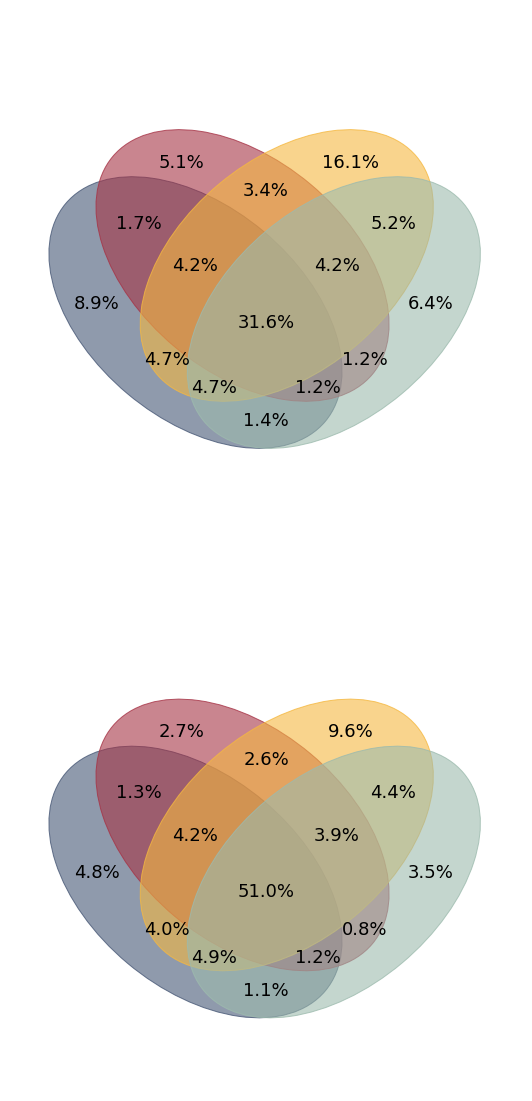

In [8]:
import venn
cmap = ["#465775", "#A63446", "#F5B841", "#9DBBAE"]
alpha = 0.60

# LOOPS
venn_df_all = {}

for dots_df, s in zip(loops_df_list, samples):

    rows_as_tuples = [f"{row[6]}-{row[7]}" for index, row in dots_df.iterrows()]
    venn_df_all[s] = set(rows_as_tuples)

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 20),
    gridspec_kw={"hspace": 0.1},
)
v = venn.venn(
    venn_df_all,
    fontsize=18,
    fmt="{percentage:.1f}%",
    cmap=cmap,
    legend_loc=None,
    ax=ax[0],
    alpha=alpha,
)


# draw venn diagram for anchors

anchors_dfs_dict = {}
for dots_df, s in zip(loops_df_list, samples):
    anchors_dfs_dict[s] = set()
    for i, entry in dots_df.iterrows():
        anchors_dfs_dict[s].add(entry[6])
        anchors_dfs_dict[s].add(entry[7])

venn.venn(
    anchors_dfs_dict,
    fontsize=18,
    fmt="{percentage:.1f}%",
    cmap=cmap,
    legend_loc=None,
	ax=ax[1],
    alpha=alpha,
)

plt.tight_layout()
plt.savefig("loops_anchors_venn.svg")

In [9]:
import dots_common

min_dist = 50_000
combs = list(itertools.product(samples, samples))
prev = []
loops_comp_ = {}
anchors_comp_ = {}
for comb in combs:
    if comb[0] != comb[1] and comb[::-1] not in prev:
        prev.append(comb)  
        print(comb)      
        i1, i2 = samples.index(comb[0]), samples.index(comb[1])
        loops_comp_[comb] = dots_common.findUniqueCommonLoops(dots_df_[i1], dots_df_[i2], accepted_range = min_dist, merge_common = True)
        anchors_comp_[comb] = dots_common.findUniqueCommonAnchors(dots_df_[i1], dots_df_[i2], accepted_range = min_dist, merge_common = True)

('t0', 't12')
('t0', 't30')
('t0', 't60')
('t12', 't30')
('t12', 't60')
('t30', 't60')


In [10]:
for comb in loops_comp_:
    for k in loops_comp_[comb]:
        loops_comp_[comb][k] = loops_comp_[comb][k].drop_duplicates(["chrom1", "start1", "start2"])

for comb in anchors_comp_:
    for k in anchors_comp_[comb]:
        anchors_comp_[comb][k] = anchors_comp_[comb][k].drop_duplicates(["chrom", "start"])

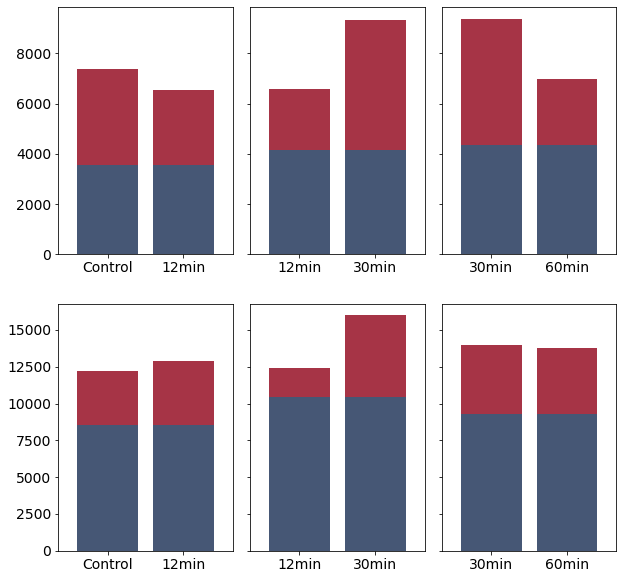

In [11]:
sample_names = ["Control", "12min", "30min", "60min"]
fig, axs = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(10, 10),
    sharey="row",
    gridspec_kw={"wspace": 0.1}
)

comps = [('t0', 't12'), ('t12', 't30'), ('t30', 't60')]

for idx, comp in enumerate(comps):
    comp_df_dict = loops_comp_[comp]
    ax = axs[0, idx]
    labels = (sample_names[idx], sample_names[idx + 1])
    weights = {
        "Common": (
            comp_df_dict["common_loops"].drop_duplicates(subset=['chrom1', 'start1', 'chrom2', 'start2']).shape[0]
        ),
        "Unique": (
            comp_df_dict["specific_loops1"].drop_duplicates(subset=['chrom1', 'start1', 'chrom2', 'start2']).shape[0],
            comp_df_dict["specific_loops2"].drop_duplicates(subset=['chrom1', 'start1', 'chrom2', 'start2']).shape[0],
        ),
    }
    
    df = pd.DataFrame(weights, index=labels)

    df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
    ax.set_xticklabels(labels=labels, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)

for idx, comp in enumerate(comps):
    comp_df_dict = anchors_comp_[comp]
    ax = axs[1, idx]
    labels = (sample_names[idx], sample_names[idx + 1])

    weights = {
        "Below": (
            comp_df_dict["common_anchors"].drop_duplicates(subset=['chrom', 'start']).shape[0]
        ),
        "Above": (
            comp_df_dict["specific_anchors1"].drop_duplicates(subset=['chrom', 'start']).shape[0],
            comp_df_dict["specific_anchors2"].drop_duplicates(subset=['chrom', 'start']).shape[0],
        ),
    }
    
    df = pd.DataFrame(weights, index=labels)

    df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
    ax.set_xticklabels(labels=labels, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.savefig("loops_anchor_counts.svg")

In [13]:
# sample_names = ["Control", "12min", "30min", "60min"]
# fig, axs = plt.subplots(
#     ncols=3,
#     nrows=2,
#     figsize=(10, 10),
#     sharey="row",
#     gridspec_kw={"wspace": 0.1}
# )

# comps = [('t0', 't12'), ('t12', 't30'), ('t30', 't60')]

# for idx, comp in enumerate(comps):
#     comp_df_dict = loops_comp_[comp]
#     ax = axs[0, idx]
#     labels = (sample_names[idx], sample_names[idx + 1])
#     weights = {
#         "Common": (
#             comp_df_dict["common_loops1"].drop_duplicates(subset=['chrom1', 'start1', 'chrom2', 'start2']).shape[0],
#             comp_df_dict["common_loops2"].drop_duplicates(subset=['chrom1', 'start1', 'chrom2', 'start2']).shape[0],
#         ),
#         "Unique": (
#             comp_df_dict["specific_loops1"].drop_duplicates(subset=['chrom1', 'start1', 'chrom2', 'start2']).shape[0],
#             comp_df_dict["specific_loops2"].drop_duplicates(subset=['chrom1', 'start1', 'chrom2', 'start2']).shape[0],
#         ),
#     }
    
#     df = pd.DataFrame(weights, index=labels)

#     df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
#     ax.set_xticklabels(labels=labels, fontsize=14)
#     ax.tick_params(axis='y', labelsize=14)

# for idx, comp in enumerate(comps):
#     comp_df_dict = anchors_comp_[comp]
#     ax = axs[1, idx]
#     labels = ("Control", sample_names[idx + 1])
#     weights = {
#         "Below": (
#             comp_df_dict["common_anchors1"].drop_duplicates(subset=['chrom', 'start']).shape[0],
#             comp_df_dict["common_anchors2"].drop_duplicates(subset=['chrom', 'start']).shape[0],
#         ),
#         "Above": (
#             comp_df_dict["specific_anchors1"].drop_duplicates(subset=['chrom', 'start']).shape[0],
#             comp_df_dict["specific_anchors2"].drop_duplicates(subset=['chrom', 'start']).shape[0],
#         ),
#     }
    
#     df = pd.DataFrame(weights, index=labels)

#     df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.8, legend=False)
#     ax.set_xticklabels(labels=labels, fontsize=14)
#     ax.tick_params(axis='y', labelsize=14)

# # plt.tight_layout()
# # plt.savefig("loops_anchor_counts.svg")

## Dots Ops Barplots

In [14]:
# min_dist = 50_000

# sample_names = ["Control", "12min", "30min", "60min"]
# fig, axs = plt.subplots(
#     ncols=3,
#     nrows=2,
#     figsize=(10, 10),
#     sharey="row",
#     gridspec_kw={"wspace": 0.1}
# )

# comps = [('t0', 't12'), ('t12', 't30'), ('t30', 't60')]

# loops_df_list_ = []

# for idx, comp in enumerate(comps):

    
#     dots_df_current = [dots_df_[samples.index(c)] for c in comp]
#     all_anchors, loops_df_list = prepare_merged_anchor(dots_df_= dots_df_current, min_dist = min_dist)
#     loops_df_list = overlap_to_all_anchors(loops_df_list, all_anchors)
#     print(comp)
#     print(all_anchors.groupby("n_intervals").size())

#     loops_df_list_.append(loops_df_list)

# # LOOPS
# for idx, comp in enumerate(comps):

#     loops_df_list = loops_df_list_[idx]
#     common_loops = set(loops_df_list[0].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)).intersection(set(loops_df_list[1].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)))
#     specific_loops1 = set(loops_df_list[0].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)).difference(set(loops_df_list[1].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)))
#     specific_loops2 = set(loops_df_list[1].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)).difference(set(loops_df_list[0].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)))

#     labels = (sample_names[idx], sample_names[idx + 1])

#     ax = axs[0, idx]

#     weights = {
#         "Common": len(common_loops),
#         "Unique": (len(specific_loops1), len(specific_loops2)),
#     }

#     df = pd.DataFrame(weights, index=labels)

#     df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.6, legend=False)
#     ax.set_xticklabels(labels=labels, fontsize=14)
#     ax.set_ylabel("Number of loops", fontsize=14)
#     ax.tick_params(axis='y', labelsize=12)


# # ANCHORS

# for idx, comp in enumerate(comps):
#         loops_df_list = loops_df_list_[idx]

#         common_anchors_1 = loops_df_list[0].iloc[:, 6].unique().tolist() + loops_df_list[0].iloc[:, 7].unique().tolist()
#         common_anchors_2 = loops_df_list[1].iloc[:, 6].unique().tolist() + loops_df_list[1].iloc[:, 7].unique().tolist()

#         common_anchors = set(common_anchors_1).intersection(set(common_anchors_2))
#         specific_anchors1 = set(common_anchors_1).difference(set(common_anchors_2))
#         specific_anchors2 = set(common_anchors_2).difference(set(common_anchors_1))

#         labels = (sample_names[idx], sample_names[idx + 1])
    
#         ax = axs[1, idx]
    
#         weights = {
#             "Common": len(common_anchors),
#             "Unique": (len(specific_anchors1), len(specific_anchors2)),
#         }
    
#         df = pd.DataFrame(weights, index=labels)
    
#         df.plot.bar(ax=ax, stacked=True, rot=0, color=["#465775", "#A63446"], width=0.6, legend=False)
#         ax.set_xticklabels(labels=labels, fontsize=14)
#         ax.set_ylabel("Number of anchors", fontsize=14)
#         ax.tick_params(axis='y', labelsize=12)

# # plt.tight_layout()
# # plt.savefig("loop_anchor_counts.svg")

## Viz dots

### Comm1, Comm2, Specific1, Specific2

In [6]:
from dots_common import findUniqueCommonLoops, findUniqueCommonAnchors

# t0 vs t12
loops = findUniqueCommonLoops(dots_df_[0], dots_df_[1], merge_common=True, accepted_range=50_000)
anchors = findUniqueCommonAnchors(dots_df_[0], dots_df_[1], merge_common=True, accepted_range=50_000)

In [13]:
for k in loops:
    df = loops[k].copy()
    df["end1"] = df["start1"] + resolution
    df["end2"] = df["start2"] + resolution
    # reorder columns
    df = df[["chrom1", "start1", "end1", "chrom2", "start2", "end2"]]
    df.drop_duplicates(['chrom1', 'start1', 'chrom2', 'start2'], inplace=True)
    df.to_csv(f"t0_t12/t0_vs_t12_{k}.tsv", sep="\t", index=False)

for k in anchors:
    df = anchors[k].copy()
    df['end'] = df['start'] + resolution
    df = df[['chrom', 'start', 'end']]
    df.drop_duplicates(inplace=True)
    df.to_csv(f"t0_t12/t0_vs_t12_{k}.tsv", sep="\t", index=False)

In [ ]:
# min_dist = 50_000

# dots_df_current = dots_df_[:2]
# all_anchors, loops_df_list = prepare_merged_anchor(dots_df_= dots_df_current, min_dist = min_dist)
# loops_df_list = overlap_to_all_anchors(loops_df_list, all_anchors)
# print(all_anchors.groupby("n_intervals").size())

# common_loops1 = set(loops_df_list[0].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)).intersection(set(loops_df_list[1].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)))
# common_loops2 = set(loops_df_list[1].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)).intersection(set(loops_df_list[0].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)))
# specific_loops1 = set(loops_df_list[0].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)).difference(set(loops_df_list[1].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)))
# specific_loops2 = set(loops_df_list[1].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)).difference(set(loops_df_list[0].iloc[:, 6:8].apply(lambda x: f"{x[0]}-{x[1]}", axis=1)))

# def get_coords(loops_set, all_anchors):
#     df_dict = {
#         "chrom1": [],
#         "start1": [],
#         "end1": [],
#         "chrom2": [],
#         "start2": [],
#         "end2": []
#     }
#     for loop in loops_set:
#         anchor1, anchor2 = loop.split("-")
#         anchor1 = all_anchors.loc[int(anchor1)]
#         anchor2 = all_anchors.loc[int(anchor2)]
#         df_dict["chrom1"].append(anchor1["chrom"])
#         df_dict["start1"].append(anchor1["start"])
#         df_dict["end1"].append(anchor1["end"])
#         df_dict["chrom2"].append(anchor2["chrom"])
#         df_dict["start2"].append(anchor2["start"])
#         df_dict["end2"].append(anchor2["end"])

#     return pd.DataFrame(df_dict)

# common_loops1_coords = get_coords(common_loops1, all_anchors)
# common_loops2_coords = get_coords(common_loops2, all_anchors)
# specific_loops1_coords = get_coords(specific_loops1, all_anchors)
# specific_loops2_coords = get_coords(specific_loops2, all_anchors)

# common_loops1_coords["length"] = common_loops1_coords["start2"] - common_loops1_coords["end1"]
# common_loops2_coords["length"] = common_loops2_coords["start2"] - common_loops2_coords["end1"]
# specific_loops1_coords["length"] = specific_loops1_coords["start2"] - specific_loops1_coords["end1"]
# specific_loops2_coords["length"] = specific_loops2_coords["start2"] - specific_loops2_coords["end1"]

# common_loops1_coords["type"] = "common_loops1"
# common_loops2_coords["type"] = "common_loops2"
# specific_loops1_coords["type"] = "specific_loops1"
# specific_loops2_coords["type"] = "specific_loops2"


# df = pd.concat([common_loops1_coords, common_loops2_coords, specific_loops1_coords, specific_loops2_coords])

# df['start1'] += (df['end1'] - df['start1']) // 20_000 * 10_000
# df['end1'] = df['start1'] + 10_000

# df['start2'] += (df['end2'] - df['start2']) // 20_000 * 10_000
# df['end2'] = df['start2'] + 10_000

In [7]:
dfs = []
loop_df = loops.copy()
for k,v in loop_df.items():
	df = v
	df["type"] = [k] * df.shape[0]
	df['end1'] = df['start1'] + resolution
	df['end2'] = df['start2'] + resolution
	df['length'] = df['start2'] - df['end1']
	dfs.append(df)

df = pd.concat(dfs)

In [12]:
apa_flank = 100_000

In [15]:
# min_dist = 30*(10_000/(2**0.5)) ### -n parameter in juicer APA
# df = df.loc[df['start2'] - df['end1'] > min_dist] 

pups_ = [
	coolpup.pileup(clr, df, features_format='bedpe', view_df=hg38_arms, expected_df=expected,
							groupby=['type'], flank=apa_flank, nproc=nproc, local=False)
							for clr, expected in zip(clrs_[:2], expected_)
]

INFO:coolpuppy:('chr1_p', 'chr1_p'): 236
INFO:coolpuppy:('chr4_p', 'chr4_p'): 96
INFO:coolpuppy:('chr2_p', 'chr2_p'): 207
INFO:coolpuppy:('chr3_p', 'chr3_p'): 136
INFO:coolpuppy:('chr5_p', 'chr5_p'): 153
INFO:coolpuppy:('chr6_p', 'chr6_p'): 258
INFO:coolpuppy:('chr4_q', 'chr4_q'): 148
INFO:coolpuppy:('chr8_p', 'chr8_p'): 82
INFO:coolpuppy:('chr7_p', 'chr7_p'): 216
INFO:coolpuppy:('chr3_q', 'chr3_q'): 249
INFO:coolpuppy:('chr1_q', 'chr1_q'): 358
INFO:coolpuppy:('chr2_q', 'chr2_q'): 221
INFO:coolpuppy:('chr9_p', 'chr9_p'): 93
INFO:coolpuppy:('chr6_q', 'chr6_q'): 234
INFO:coolpuppy:('chr8_q', 'chr8_q'): 178
INFO:coolpuppy:('chr10_p', 'chr10_p'): 106
INFO:coolpuppy:('chr11_p', 'chr11_p'): 114
INFO:coolpuppy:('chr7_q', 'chr7_q'): 170
INFO:coolpuppy:('chr12_p', 'chr12_p'): 94
INFO:coolpuppy:('chr9_q', 'chr9_q'): 203
INFO:coolpuppy:('chr5_q', 'chr5_q'): 403
INFO:coolpuppy:('chr10_q', 'chr10_q'): 133
INFO:coolpuppy:('chr13_q', 'chr13_q'): 151
INFO:coolpuppy:('chr11_q', 'chr11_q'): 168
INFO:coo

In [16]:
def min_max_comp(data__):
	vmin = []
	vmax = []
	for data_ in data__:
		data_ = data_.data
		for data in data_:
			vmin.append(np.nanmin(data))
			vmax.append(np.nanmax(data))
	vmax = np.nanmax(vmax)
	vmin = np.nanmin(vmin)		
	if vmax >= 1:
		vmin = 2 ** -np.log2(vmax)
	return vmin, vmax		

In [16]:
def get_corner_scores(data, n_bins):
    center_idx = data.shape[0] // 2
    center_score = data[center_idx, center_idx]
    tl = np.nanmean(data[:n_bins, :n_bins]) 
    br = np.nanmean(data[-n_bins:, -n_bins:])
    tr = np.nanmean(data[:n_bins, -n_bins:])
    bl = np.nanmean(data[-n_bins:, :n_bins])

    return [
        center_score / tl, 
        center_score / tr, 
        center_score / bl, 
        center_score / br]

def P2M(data):
    total = np.nansum(data)
    center_idx = data.shape[0] // 2
    center_score = data[center_idx, center_idx]
    return center_score / ((total - center_score) / (data.size - 1))

def P2LL(data, n_bins):
    center_idx = data.shape[0] // 2
    center_score = data[center_idx, center_idx]
    bl = np.nanmean(data[-n_bins:, :n_bins])
    return center_score / bl

def central_score(data, n):
    c = data.shape[0] // 2
    return np.nanmean(data[c - n // 2 : c + n // 2 + 1, c - n // 2 : c + n // 2 + 1])


In [14]:
from coolpuppy.lib import numutils, puputils
corner_size = 6
central_size = 1

In [26]:


for pup in pups_:
    pup['central_score'] = pup.apply(
                    lambda x: central_score(x['data'], central_size), axis=1
                )

for pup in pups_:
    pup['corner_scores'] = pup.apply(
                    lambda x: get_corner_scores(x['data'], corner_size), axis=1
                )

for pup in pups_:    
    pup['P2M'] = pup.apply(
                    lambda x: P2M(x['data']), axis=1
                )

for pup in pups_:    
    pup['P2LL'] = pup.apply(
                    lambda x: P2LL(x['data'], corner_size), axis=1
                )

In [27]:
pups_reordered = []
#re_order = ["common_loops1", "common_loops2", "specific_loops1", "specific_loops2", "all"]
re_order = ["common_loops", "specific_loops1", "specific_loops2", "all"]

for pup in pups_:
    pup_df = pup.copy()

    pup_df.set_index("type", inplace=True)
    pup_df = pup_df.reindex(re_order)
    pup_df["type"] = pup_df.index
    pup_df.reset_index(drop=True, inplace=True)
    pups_reordered.append(pup_df)

0    /home/carlos/Desktop/manuscripts/notebooks/mat...
1    /home/carlos/Desktop/manuscripts/notebooks/mat...
2    /home/carlos/Desktop/manuscripts/notebooks/mat...
3    /home/carlos/Desktop/manuscripts/notebooks/mat...
Name: clr, dtype: object
0    /home/carlos/Desktop/manuscripts/notebooks/mat...
1    /home/carlos/Desktop/manuscripts/notebooks/mat...
2    /home/carlos/Desktop/manuscripts/notebooks/mat...
3    /home/carlos/Desktop/manuscripts/notebooks/mat...
Name: clr, dtype: object


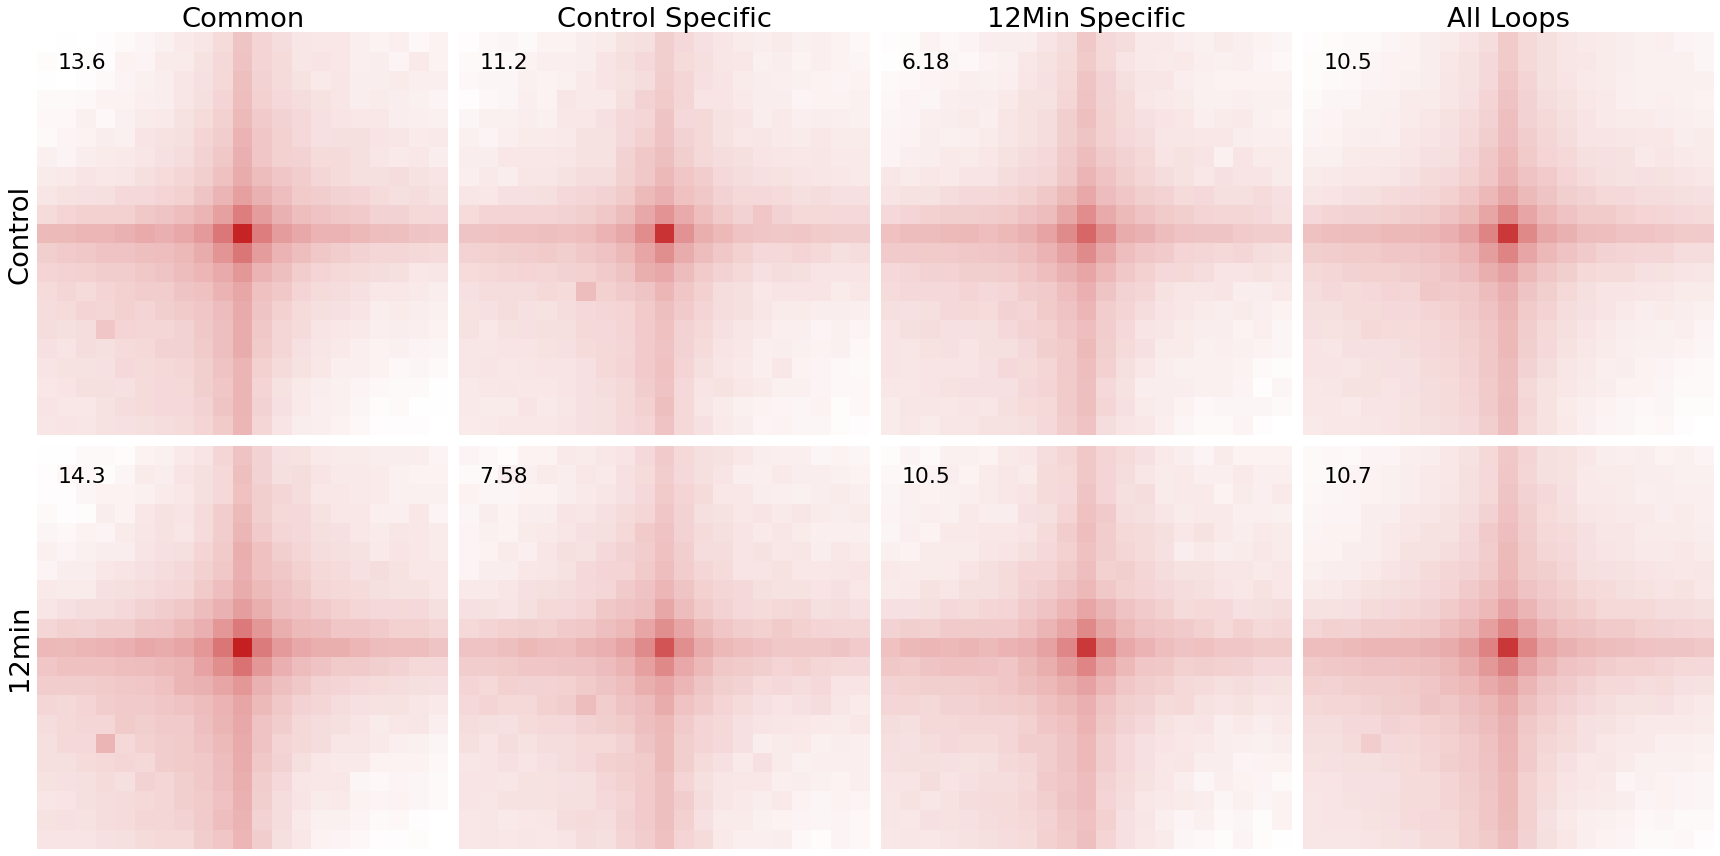

In [43]:
scores_type = "central_score" # "corner_scores" or "central_score" or "P2M" or "P2LL"

vmin, vmax = min_max_comp(pups_reordered)
from matplotlib.colors import LogNorm, Normalize
from matplotlib import patches
norm = LogNorm(vmin=vmin, vmax=vmax)
height =6
fig, axs = plt.subplots(
      ncols=4,
      nrows=len(pups_reordered),
	figsize=(24, height*2),
      sharex=True,
      sharey=True,
)


from matplotlib.colors import LinearSegmentedColormap
cmp = LinearSegmentedColormap.from_list("custom_cmp", ["white", "white", "#C42021"], N=256)

font_scale = 2
sample_names = ["Control", "12min"]

# types_dict = {
#       "specific_loops1": "Control Unique", 
#       "specific_loops2": "12Min Unique", 
#       "common_loops1": "Control Common",
#       "common_loops2": "12Min Common",  
#       "all": "All Loops"}

types_dict = {
      "specific_loops1": "Control Specific", 
      "specific_loops2": "12Min Specific", 
      "common_loops": "Common",  
      "all": "All Loops"}

for i, pup in enumerate(pups_reordered):
      print(pup.clr)
      types =  pup.type

      for idx, ax in enumerate(axs[i, :]):
            s = sns.heatmap(
                  pup.iloc[idx].data,
                  cmap=cmp,
                  norm=norm,
                  ax=ax,
                  cbar=False,
            )
            
            current_type = types[idx]

            if i == 0:
                  s.set_title(types_dict[current_type], fontsize=2.5 * (4.94 + height))
            s.set_xticks([])
            s.set_xticklabels([])
            s.set_yticks([])
            s.set_yticklabels([])
            
            mtx_size = pup.iloc[idx].data.shape[0]

            if idx == 0:
                  s.set_ylabel(sample_names[i], fontsize=2.5 * (4.94 + height))

            if scores_type == "central_score":
                  score = pup.central_score[idx]
                  ax.text(
                        s=f"{score:.3g}",
                        y=0.95,
                        x=0.05,
                        ha="left",
                        va="top",
                        size=font_scale * (4.94 + height),
                        transform=ax.transAxes,
                  )
            elif scores_type == "P2M":
                  p2m = pup.P2M[idx]
                  ax.text(
                        s=f"{p2m:.3g}",
                        y=0.95,
                        x=0.05,
                        ha="left",
                        va="top",
                        size=font_scale * (4.94 + height),
                        transform=ax.transAxes,
                  )
            elif scores_type == "corner_scores":
                  corner_scores = pup.corner_scores[idx]
                  # top left
                  ax.text(
                        s=f"{corner_scores[0]:.3g}",
                        y=0.95,
                        x=0.05,
                        ha="left",
                        va="top",
                        size=font_scale * (4.94 + height),
                        transform=ax.transAxes,
                  )
                  
                  # add patch
                  rect = patches.Rectangle((0, 0), corner_size, corner_size, linewidth=2, edgecolor='#465775', facecolor='none')
                  ax.add_patch(rect)

                  # top right
                  ax.text(
                        s=f"{corner_scores[1]:.3g}",
                        y=0.95,
                        x=0.95,
                        ha="right",
                        va="top",
                        size=font_scale * (4.94 + height),
                        transform=ax.transAxes,
                  )

                  # add patch
                  rect = patches.Rectangle((mtx_size - corner_size, 0), corner_size, corner_size, linewidth=2, edgecolor='#465775', facecolor='none')
                  ax.add_patch(rect)


                  # bottom left
                  ax.text(
                        s=f"{corner_scores[2]:.3g}",
                        y=0.05,
                        x=0.05,
                        ha="left",
                        va="bottom",
                        size=font_scale * (4.94 + height),
                        transform=ax.transAxes,
                  )
                  
                  # add patch
                  rect = patches.Rectangle((0, mtx_size - corner_size), corner_size, corner_size, linewidth=2, edgecolor='#465775', facecolor='none')
                  ax.add_patch(rect)

                  # bottom right
                  ax.text(
                        s=f"{corner_scores[3]:.3g}",
                        y=0.05,
                        x=0.95,
                        ha="right",
                        va="bottom",
                        size=font_scale * (4.94 + height),
                        transform=ax.transAxes,
                  )

                  # add patch
                  rect = patches.Rectangle((mtx_size - corner_size, mtx_size - corner_size), corner_size, corner_size, linewidth=2, edgecolor='#465775', facecolor='none')
                  ax.add_patch(rect)


            elif scores_type == "P2LL":
                  p2ll = pup.P2LL[idx]
                  ax.text(
                        s=f"{p2ll:.3g}",
                        y=0.15,
                        x=0.05,
                        ha="left",
                        va="top",
                        size=font_scale * (4.94 + height),
                        transform=ax.transAxes,
                  )

fig.set_tight_layout(True)

#fig.suptitle("Control vs 12min", fontsize=font_scale * (4.94 + height))

plt.savefig(f"t0_t12_loop_str_{scores_type}.svg")

## Dot Score ~ Repair

In [8]:
chrom_sizes = bioframe.fetch_chromsizes("hg38")[:23]
def get_mean_bw(bw, chrom_sizes):
    for chrom in chrom_sizes.index:
        start, end = 0, chrom_sizes.loc[chrom] // 10000 * 10000
        yield np.nanmean(bbi.fetch(bw, chrom, start, end, bins=chrom_sizes.loc[chrom] // 1000))

BWS = {
    'xr-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_real_over_sim_res1000.bw',
    'xr-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_real_over_sim_res1000.bw',
    'ds-64-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_64_real_over_sim_res1000.bw',
    'ds-cpd-over-sim': '/home/carlos/Desktop/manuscripts/notebooks/bws/DS_CPD_real_over_sim_res1000.bw',
    'rep-eff-64': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_64_rep_eff_res1000.bw',
    'rep-eff-cpd': '/home/carlos/Desktop/manuscripts/notebooks/bws/XR_CPD_rep_eff_res1000.bw',
    #'ctcf': '/cta/users/vkaya/hi-c/work/hela/notebooks/bw/ctcf.foi.bigWig',
    }

MEANS_BW = {}
for k in BWS:
    mean_val = np.mean(list(get_mean_bw(BWS[k], chrom_sizes)))
    print(k, mean_val)
    MEANS_BW[k] = mean_val

xr-64-over-sim 1.1196280573820672
xr-cpd-over-sim 1.1868305407819189
ds-64-over-sim 1.23405186005681
ds-cpd-over-sim 1.2698717973554339
rep-eff-64 1.482119054797605
rep-eff-cpd 1.567885930820114


In [9]:
def _bw_data(
    curr_DF, 
    flank, 
    n_bins_start, 
    n_bins_end, 
    n_bins_main, 
    mean_norm=True):

    start_data = {k: bbi.stackup(v,
                            curr_DF.chrom,
                            curr_DF.start - flank,
                            curr_DF.start,
                            bins=n_bins_start) 
                            for k, v in BWS.items()
                            }
    main_data = {k: bbi.stackup(v,
                            curr_DF.chrom,
                            curr_DF.start,
                            curr_DF.end,
                            bins=n_bins_main) 
                            for k, v in BWS.items()
                            }
    end_data = {k: bbi.stackup(v,
                            curr_DF.chrom,
                            curr_DF.end,
                            curr_DF.end + flank,
                            bins=n_bins_end)
                            for k, v in BWS.items()
                            }

    if mean_norm:
        for k in start_data:
            start_data[k] = start_data[k] / MEANS_BW[k]
        for k in main_data:
            main_data[k] = main_data[k] / MEANS_BW[k]
        for k in end_data:
            end_data[k] = end_data[k] / MEANS_BW[k]
    return start_data, main_data, end_data

In [10]:
def tr_to_rest(data, n_bins):
    mid_point = data.shape[0] // 2
    tr = np.nanmean(data[:n_bins, -n_bins:])
    bl = np.nanmean(data[-n_bins:, :n_bins])
    br = np.nanmean(data[-n_bins:, -n_bins:])
    tl = np.nanmean(data[:n_bins, :n_bins])
    return tr / np.nanmean([bl, br, tl]) * P2M(data)

In [18]:
from sklearn.preprocessing import QuantileTransformer

length_filter = None #(min_dist, 10_000_000) # None for no filter, Only keep loops in range (min, max)

loops_map_idx = { # 0 for control idx, 1 for 12min idx
    'common_loops': 0,
    'specific_loops1': 0, 
    'specific_loops2': 1}


bw_per_key = []
loop_dfs = []

for i, loop_type in enumerate(loops_map_idx.keys()):
    loop_df = loops[loop_type].copy().reset_index(drop=True)
    loop_df['loop_len'] = loop_df['start2'] - loop_df['end1']
    print(loop_type, np.mean(loop_df['loop_len']))
    print(loop_type, np.median(loop_df['loop_len']))

    if length_filter is not None:
        loop_df = loop_df[(loop_df['loop_len'] > length_filter[0]) & (loop_df['loop_len'] < length_filter[1])]

    map_idx = loops_map_idx[loop_type]
    loop_df['end1'] = loop_df['start1'] + resolution
    loop_df['end2'] = loop_df['start2'] + resolution

    
    stack = cooltools.pileup(clrs_[map_idx], loop_df, view_df=hg38_arms, expected_df=expected_[map_idx], flank=apa_flank, nproc=nproc)
    center_idx = stack.shape[0] // 2
    center_scores = stack[center_idx, center_idx, :]
    center_scores_QT = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=42).fit_transform(center_scores.reshape(-1, 1)).reshape(-1)
    bl_scores_QT = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=42).fit_transform(np.nanmean(stack[-corner_size:, :corner_size, :], axis=(0,1)).reshape(-1, 1)).reshape(-1)
    rank_anchor_to_rank_loop_body = center_scores_QT / bl_scores_QT

    # loop strength calculation
    p2m_scores = []
    bl_scores = []
    p2ll_scores = []
    tr_to_rest_scores = []
    center_scores_QT_p2ll = []
    center_scores_QT_tr = []
    center_scores_QT_p2m = []
    anchor_body = []
    for stack_idx in range(stack.shape[2]):
        data = stack[:,:,stack_idx]
        p2m_scores.append(P2M(data))
        p2ll_scores.append(P2LL(data, corner_size))
        tr_to_rest_scores.append(tr_to_rest(data, corner_size))
        center_scores_QT_p2ll.append(center_scores_QT[stack_idx] * P2LL(data, corner_size))
        center_scores_QT_tr.append(center_scores_QT[stack_idx] * tr_to_rest(data, corner_size))
        center_scores_QT_p2m.append(center_scores_QT[stack_idx] * P2M(data))
        anchor_body.append(rank_anchor_to_rank_loop_body[stack_idx] * P2M(data))


    loop_df['p2m_scores_raw'] = p2m_scores
    loop_df['p2ll_scores_raw'] = p2ll_scores
    loop_df['tr_to_rest_scores_raw'] = tr_to_rest_scores
    loop_df['center_QT_p2ll_scores_raw'] = center_scores_QT_p2ll
    loop_df['center_QT_tr_scores_raw'] = center_scores_QT_tr
    loop_df['center_QT_p2m_scores_raw'] = center_scores_QT_p2m
    loop_df['anchor_body_scores_raw'] = anchor_body

    # convert inf to nan
    loop_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    loop_df.dropna(inplace=True)

    loop_df['p2m_scores'] = pd.qcut(loop_df['p2m_scores_raw'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    loop_df['p2ll_scores'] = pd.qcut(loop_df['p2ll_scores_raw'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    loop_df['tr_to_rest_scores'] = pd.qcut(loop_df['tr_to_rest_scores_raw'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    loop_df['center_QT_p2ll_scores'] = pd.qcut(loop_df['center_QT_p2ll_scores_raw'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    loop_df['center_QT_tr_scores'] = pd.qcut(loop_df['center_QT_tr_scores_raw'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    loop_df['center_QT_p2m_scores'] = pd.qcut(loop_df['center_QT_p2m_scores_raw'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    loop_df['anchor_body_scores'] = pd.qcut(loop_df['anchor_body_scores_raw'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
    
    loop_df['start'] = loop_df['start1']
    loop_df['end'] = loop_df['end2']
    loop_df['chrom'] = loop_df['chrom1'] 
    loop_dfs.append(loop_df)

print(loops_map_idx)

common_loops 303642.75668073137
common_loops 230000.0


/tmp/ipykernel_19368/2299760687.py:33: RuntimeWarning: divide by zero encountered in divide
  rank_anchor_to_rank_loop_body = center_scores_QT / bl_scores_QT
/tmp/ipykernel_19368/3396646923.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  return center_score / bl


specific_loops1 325776.5596450013
specific_loops1 230000.0


/tmp/ipykernel_19368/2299760687.py:33: RuntimeWarning: divide by zero encountered in divide
  rank_anchor_to_rank_loop_body = center_scores_QT / bl_scores_QT
/tmp/ipykernel_19368/3396646923.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  return center_score / bl


specific_loops2 319561.4328757951
specific_loops2 240000.0


/tmp/ipykernel_19368/2299760687.py:32: RuntimeWarning: Mean of empty slice
  bl_scores_QT = QuantileTransformer(n_quantiles=1000, output_distribution='uniform', random_state=42).fit_transform(np.nanmean(stack[-corner_size:, :corner_size, :], axis=(0,1)).reshape(-1, 1)).reshape(-1)
/tmp/ipykernel_19368/2299760687.py:33: RuntimeWarning: divide by zero encountered in divide
  rank_anchor_to_rank_loop_body = center_scores_QT / bl_scores_QT


{'common_loops': 0, 'specific_loops1': 0, 'specific_loops2': 1}


/tmp/ipykernel_19368/3396646923.py:24: RuntimeWarning: Mean of empty slice
  bl = np.nanmean(data[-n_bins:, :n_bins])
/tmp/ipykernel_19368/4026915237.py:3: RuntimeWarning: Mean of empty slice
  tr = np.nanmean(data[:n_bins, -n_bins:])
/tmp/ipykernel_19368/4026915237.py:4: RuntimeWarning: Mean of empty slice
  bl = np.nanmean(data[-n_bins:, :n_bins])
/tmp/ipykernel_19368/4026915237.py:5: RuntimeWarning: Mean of empty slice
  br = np.nanmean(data[-n_bins:, -n_bins:])
/tmp/ipykernel_19368/4026915237.py:6: RuntimeWarning: Mean of empty slice
  tl = np.nanmean(data[:n_bins, :n_bins])
/tmp/ipykernel_19368/4026915237.py:7: RuntimeWarning: Mean of empty slice
  return tr / np.nanmean([bl, br, tl]) * P2M(data)


In [50]:
n_bins_flank, n_bins_main = 100, 315
bw_per_key = [_bw_data(
    loop_df, 
    flank=apa_flank, 
    n_bins_start=n_bins_flank, 
    n_bins_end=n_bins_flank, 
    n_bins_main=n_bins_main) for loop_df in loop_dfs]

In [53]:
from scipy.ndimage import gaussian_filter1d

sigma = 2 # None for no smoothing
score_types = ['p2m_scores', 'p2ll_scores', 'tr_to_rest_scores', 'center_QT_p2ll_scores', 'center_QT_tr_scores', 'center_QT_p2m_scores']


types_dict = {
      "specific_loops1": "Control Specific", 
      "specific_loops2": "12Min Specific", 
      "common_loops": "Common", 
      "all": "All Loops"}

rep_names = ['rep-eff-cpd', 'rep-eff-64', 'xr-cpd-over-sim', 'xr-64-over-sim', 'ds-cpd-over-sim', 'ds-64-over-sim']
rep_names_dict = {
    'rep-eff-cpd': 'Repair Efficiency - CPD',
    'rep-eff-64': 'Repair Efficiency - 6-4PP',
    'xr-cpd-over-sim': 'CPD - Normalized Repair Levels',
    'xr-64-over-sim': '6-4PP - Normalized Repair Levels',
    'ds-cpd-over-sim': 'CPD - Normalized Damage Sensitivity',
    'ds-64-over-sim': '6-4PP - Normalized Damage Sensitivity',
}

for scores_type_for_quantile in score_types:

    for rep_name in rep_names:

        fig, ax = plt.subplots(
            nrows=1, ncols=3,
            figsize=(24, 6),
            sharex=True,
            sharey=True,
            )

        for i, (start_data, main_data, end_data) in enumerate(bw_per_key):   

            loop_type = list(loops_map_idx.keys())[i]

            plot_dict = {
                "n_range": [],
                "data": [],
                "score_label": [],
                }

            current_loop_df = loop_dfs[i].copy().reset_index(drop=True)
            for score_label in ['Q1', 'Q2', 'Q3', 'Q4']:

                current_loop_df_idx = current_loop_df[current_loop_df[scores_type_for_quantile] == score_label].index.to_list()
                
                main = np.nanmean(np.take(main_data[rep_name], current_loop_df_idx, 0), axis=0)
                start = np.nanmean(np.take(start_data[rep_name], current_loop_df_idx, 0), axis=0)
                end = np.nanmean(np.take(end_data[rep_name], current_loop_df_idx, 0), axis=0)

                data = np.hstack([start, main, end]) 
                data = data if sigma == None else gaussian_filter1d(data, sigma=sigma)

                plot_dict["n_range"].extend(list(np.arange(data.shape[0])))
                plot_dict["data"].extend(list(data))

                score_label_size = f"{score_label} n={len(current_loop_df_idx)}"
                # score label should be size of the number of loops in that quantile, and mean of the score
                raw_score_name = scores_type_for_quantile.replace("_scores", "_scores_raw")
                mean_score = np.nanmean(current_loop_df[current_loop_df[scores_type_for_quantile] == score_label][raw_score_name])
                score_label = f"{score_label} n={len(current_loop_df_idx)}, mean={mean_score.round(3)}"
                plot_dict["score_label"].extend([score_label] * data.shape[0])
                
                #plot_dict["score_label"].extend([score_label_size] * data.shape[0])
            
########################     Mean       ##########################################################
            plot_dict_mean = {
                "n_range": [],
                "data": [],
                }
            
            main = np.nanmean(main_data[rep_name], axis=0)
            start = np.nanmean(start_data[rep_name], axis=0)
            end = np.nanmean(end_data[rep_name], axis=0)

            data = np.hstack([start, main, end]) 
            data = data if sigma == None else gaussian_filter1d(data, sigma=sigma)

            plot_dict_mean["n_range"].extend(list(np.arange(data.shape[0])))
            plot_dict_mean["data"].extend(list(data))

##############################################################################################################

            color_palette = ["#9DBBAE", "#F5B841", "#A63446", "#465775"]

            plot_df = pd.DataFrame(plot_dict)

            l = sns.lineplot(
                x="n_range",
                y="data",
                hue="score_label",
                data=plot_df,
                ax=ax[i],
                palette=color_palette,
                legend=True,
                alpha=1,
                )

            # dashed line
            mean_l = sns.lineplot(
                x="n_range",
                y="data",
                data=pd.DataFrame(plot_dict_mean),
                ax=ax[i],
                color="red",
                legend=False,
                alpha=0.6,
                )
            l.lines[-1].set_linestyle("--")
            
            # change legend title
            new_title = 'Loop Strength Quantiles'
            l.legend_.set_title(new_title)

            l.set_title(
                types_dict[loop_type],
                fontsize=16)

            # increase font size 
            l.tick_params(axis='both', which='major', labelsize=20)
            l.tick_params(axis='both', which='minor', labelsize=20)

            total_bins = n_bins_flank + n_bins_flank + n_bins_main
            l.set_xticks([n_bins_flank, total_bins//2, total_bins - n_bins_flank])
            l.set_xticklabels(["5' Anchor", 'Intra-Loop', "3' Anchor"], fontsize=12)
            l.set_xlabel('')

            l.set_ylabel(rep_names_dict[rep_name], fontsize=14)

            l.axvline(n_bins_flank, linestyle='-', color='black', alpha=0.6)
            l.axvline(total_bins - n_bins_flank, linestyle='-', color='black', alpha=0.6)
            l.tick_params(axis='both', which='major', labelsize=12)

            for tick in l.get_xticklabels():
                tick.set_rotation(15)

            # remove legend
            l.get_legend().remove()

        if length_filter is not None:
            len_name = f"{length_filter[0]//1000}_{length_filter[1]//1000}kb"
        else:
            len_name = "All"
        flank_name = f"{apa_flank//1000}kb"
        #fig.savefig(f"loop_str_quantiles/t0_t12_loop_strQuantiles_{scores_type_for_quantile}_{rep_name}_size{len_name}_flank{flank_name}.png")
        fig.savefig(f"loop_str_quantiles/t0_t12_loop_strQuantiles_{scores_type_for_quantile}_{rep_name}_size{len_name}_flank{flank_name}.svg")
        fig.clf()

/tmp/ipykernel_7956/4090145556.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(


<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

<Figure size 1728x432 with 0 Axes>

## Flank scaled

In [ ]:
# def _bw_data_flank_scaled(
#     curr_DF,
#     flank_ratio=0.1,
#     total_bins=120,
#     mean_norm=True):
    
#     body_length = curr_DF.end - curr_DF.start
#     flank_size = (body_length * flank_ratio).astype(int)

#     main_data = {k: bbi.stackup(v,
#                             curr_DF.chrom,
#                             curr_DF.start - flank_size,
#                             curr_DF.end + flank_size,
#                             bins=120) 
#                             for k, v in BWS.items()
#                             }

#     if mean_norm:
#         for k in main_data:
#             main_data[k] = main_data[k] / MEANS_BW[k]
            
#     return main_data

In [ ]:
# flank_ratio = 0.25
# main_bins = 300
# total_bins = 300 + 2 * int(main_bins * flank_ratio)
# bw_per_key_scaled = [_bw_data_flank_scaled(loop_df, flank_ratio=flank_ratio, total_bins=total_bins) for loop_df in loop_dfs]

In [ ]:
# from scipy.ndimage import gaussian_filter1d

# sigma = None # None for no smoothing
# score_types = ['p2m_scores', 'p2ll_scores', 'tr_to_rest_scores', 'center_QT_p2ll_scores', 'center_QT_tr_scores', 'center_QT_p2m_scores']

# types_dict = {
#       "specific_loops1": "Unique Loops - Control", 
#       "specific_loops2": "Unique Loops - 12 Min", 
#       "common_loops": "Common Loops",  
#       "all": "All Loops"}

# rep_names = ['rep-eff-cpd', 'rep-eff-64', 'xr-cpd-over-sim', 'xr-64-over-sim', 'ds-cpd-over-sim', 'ds-64-over-sim']
# rep_names_dict = {
#     'rep-eff-cpd': 'Repair Efficiency - CPD',
#     'rep-eff-64': 'Repair Efficiency - 6-4PP',
#     'xr-cpd-over-sim': 'CPD - Repair Levels',
#     'xr-64-over-sim': '6-4PP - Repair Levels',
#     'ds-cpd-over-sim': 'CPD - Damage Sensitivity',
#     'ds-64-over-sim': '6-4PP - Damage Sensitivity',
# }
# for scores_type_for_quantile in score_types:

#     for rep_name in rep_names:

#         fig, ax = plt.subplots(
#             nrows=1, ncols=3,
#             figsize=(20, 10),
#             sharex=True,
#             sharey=True,
#             )

#         for i, main_data in enumerate(bw_per_key_scaled):   

#             loop_type = list(loops_map_idx.keys())[i]

#             plot_dict = {
#                 "n_range": [],
#                 "data": [],
#                 "score_label": [],
#                 }

#             current_loop_df = loop_dfs[i].copy().reset_index(drop=True)
#             for score_label in ['Q1', 'Q2', 'Q3', 'Q4']:

#                 current_loop_df_idx = current_loop_df[current_loop_df[scores_type_for_quantile] == score_label].index.to_list()
                
#                 data = np.nanmean(np.take(main_data[rep_name], current_loop_df_idx, 0), axis=0)
#                 data = data if sigma == None else gaussian_filter1d(data, sigma=sigma)

#                 plot_dict["n_range"].extend(list(np.arange(data.shape[0])))
#                 plot_dict["data"].extend(list(data))

#                 score_label_size = f"{score_label} n={len(current_loop_df_idx)}"
#                 plot_dict["score_label"].extend([score_label_size] * data.shape[0])
            
# ########################     Mean       ##########################################################
#             plot_dict_mean = {
#                 "n_range": [],
#                 "data": [],
#                 }
            
#             data = np.nanmean(main_data[rep_name], axis=0)
#             data = data if sigma == None else gaussian_filter1d(data, sigma=sigma)

#             plot_dict_mean["n_range"].extend(list(np.arange(data.shape[0])))
#             plot_dict_mean["data"].extend(list(data))

# ##############################################################################################################

#             color_palette = ["#9DBBAE", "#F5B841", "#A63446", "#465775"]

#             plot_df = pd.DataFrame(plot_dict)

#             l = sns.lineplot(
#                 x="n_range",
#                 y="data",
#                 hue="score_label",
#                 data=plot_df,
#                 ax=ax[i],
#                 palette=color_palette,
#                 legend=True,
#                 alpha=0.9,
#                 )

#             # dashed line
#             mean_l = sns.lineplot(
#                 x="n_range",
#                 y="data",
#                 data=pd.DataFrame(plot_dict_mean),
#                 ax=ax[i],
#                 color="red",
#                 legend=False,
#                 alpha=0.8,
#                 )
#             l.lines[-1].set_linestyle("--")
            
#             # change legend title
#             new_title = 'Loop Strength Quantiles'
#             l.legend_.set_title(new_title)

#             l.set_title(
#                 types_dict[loop_type],
#                 fontsize=20)

#             # increase font size 
#             # l.tick_params(axis='both', which='major', labelsize=20)
#             # l.tick_params(axis='both', which='minor', labelsize=20)

#             # flanks = (total_bins - main_bins) // 2
#             # l.set_xticks([flanks, main_bins//2, total_bins-flanks])
#             # l.set_xticklabels(["5' Anchor", 'Intra-Loop', "3' Anchor"], fontsize=14)
#             # l.set_xlabel('')

#             # l.set_ylabel(rep_names_dict[rep_name], fontsize=20)

#             # l.axvline(flanks, linestyle='-', color='black', alpha=0.8)
#             # l.axvline(total_bins-flanks, linestyle='-', color='black', alpha=0.8)
#             # l.tick_params(axis='both', which='major', labelsize=14)

#         if length_filter is not None:
#             len_name = f"{length_filter[0]//1000}_{length_filter[1]//1000}kb"
#         else:
#             len_name = "All"
#         flank_name = f"{apa_flank//1000}kb"
#         fig.savefig(f"loop_str_quantiles_mc_{merge_common}/t0_t12_loop_strQuantiles_{scores_type_for_quantile}_{rep_name}_size{len_name}_flank{flank_name}.svg")
#         #fig.savefig(f"loop_str_quantiles/t0_t12_loop_strQuantiles_{scores_type_for_quantile}_{rep_name}_size{len_name}_flank{flank_name}.png", dpi=600)
#         fig.clf()

## Dots ~ Size

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
lens = []
plot_df = {
    'len': [],
    'sample': [],
}
sample_names= ["Control", "12min", "30min", "60min"]
for i in range(4):
    dots_df = dots_df_[i].copy()
    dots_df['loop_length'] = dots_df['end2'] - dots_df['start1']
    plot_df['len'].extend(list(dots_df['loop_length']))
    plot_df['sample'].extend([sample_names[i]] * dots_df.shape[0])
plot_df = pd.DataFrame(plot_df)
s = sns.histplot(plot_df, x="len", hue="sample", bins=200, kde=False, stat="percent", common_norm=False, log_scale=False, ax=ax, fill=False, linewidth=.5)
s.set_xlim(100_000, 1e6)
# set x ticks 
s.set_xticks(np.arange(100_000, 1e6, 50_000), minor=True)
# set x labels to rotate
s.set_xticklabels(s.get_xticklabels(), rotation=45)

In [ ]:
# dots_df = dots_df_[0].copy()
# dots_df['loop_length'] = dots_df['end2'] - dots_df['start1']

# use common loops between 0 - 12

dots_df = loops_comp_[('t0', 't12')]['common_loops'].copy()
dots_df['loop_length'] = dots_df['start2'] - dots_df['start1']

In [ ]:
interval_size = 1000
bws_per_key = {}
for k in BWS.keys():
    per_chr = []
    for chrName in chrom_sizes.index:
        chrLen = chrom_sizes.loc[chrName]
        start, end = 0, chrLen // interval_size * interval_size
        n_bins = end // interval_size
        arr_chr = bbi.fetch(
            BWS[k],
            chrName,
            start,
            end,
            bins=n_bins,
        )
        
        per_chr.append(arr_chr / MEANS_BW[k])
    bws_per_key[k] = per_chr

chrom_sizes = bioframe.fetch_chromsizes("hg38")[:23]

data_df = []
for k in BWS.keys():

    regions = {
        "len": [],
        "data": [],
        "data_type": k,
    }

    for i, row in dots_df.iterrows():
        chrom, start, end = row['chrom1'], row['start1'], row['end2']
        chrom_idx = chrom_sizes.index.get_loc(chrom)
        curr_arr = bws_per_key[k][chrom_idx][start//interval_size:end//interval_size]
        total_intervals = (end - start) // interval_size
        tad_length = end - start
        
        if len(curr_arr) != total_intervals: # filter out regions that exceed the chromosome length
            continue
        if len(np.where(curr_arr == np.nan)[0]) >= len(curr_arr * 10 / 100):
            print("nan")
            continue
        tad_mean_val = np.nanmean(curr_arr)

        regions["len"].append(tad_length)
        regions["data"].append(tad_mean_val)

    tad_df = pd.DataFrame(regions)
    data_df.append(tad_df)

data_df = pd.concat(data_df)

In [ ]:
from scipy.stats import pearsonr

fig, ax = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(20, 7.5),
    sharex=True,
    sharey=True,)

data_names = ['rep-eff-64', 'rep-eff-cpd', 'xr-64-over-sim', 'xr-cpd-over-sim', 'ds-64-over-sim', 'ds-cpd-over-sim']
data_names = ['xr-cpd-over-sim', 'xr-64-over-sim']
for i, rep_name in enumerate(data_names):
    data = data_df.copy().reset_index(drop=True)
    data = data.loc[data['data_type'] == rep_name]
    data = data.loc[data['len'] <= 1.5e6]
    data['len'] = data['len'] / 1e6
    data = data.loc[data["data"] != 0].reset_index(drop=True).copy()
    ax_now = ax[i]
    s = sns.regplot(
        data=data,
        x='len', y='data', 
        # change marker size to 1
        scatter_kws = {"color": "#465775", "alpha": 1, "s": 4},
        line_kws = {"color": "#C1121F", "lw": 2}, fit_reg=True, order=1,
        ax=ax[i])
    s.axhline(1, color='black', linestyle='--', lw=2)

    r = pearsonr(x=data['len'], y=data["data"])[0]
    s.text(0.80, 0.90, f"r = {r:.3f}", transform=s.transAxes, fontsize=16)

    ax_now.ticklabel_format(style='plain', axis='both')
    ax_now.axhline(1, color='black', linestyle='--', lw=2)
    ax_now.tick_params(axis='both', which='major', labelsize=14)
    ax_now.set_xlabel('Loop Length (Mb)', fontsize=18)
    ax_now.set_ylabel('Normalized Repair Levels', fontsize=18) if i == 0 else ax_now.set_ylabel('')

fig.savefig('loops_str_scores_sizes_repair_levels.svg', bbox_inches='tight')

## Loop scores ~ Damages

In [ ]:
#rep_names = ['ds-64-over-sim', 'ds-cpd-over-sim']
rep_names = ['ds-cpd-over-sim']
score_name = "p2m_scores"

fig, ax = plt.subplots(
    ncols=3,
    nrows=1,
    figsize=(20, 10),
    sharex=True,
    sharey=True,
    )

for idx, df in enumerate(loop_dfs):
    plot_dict = {
        "n_range": [],
        "data": [],
        "score_label": [],
        }
    for score_label in ['Q1', 'Q2', 'Q3', 'Q4']:
        df_now = df[df[score_name] == score_label].reset_index()
        _, main_data, _ = _bw_data(df_now, flank=apa_flank, n_bins_start=1, n_bins_end=1, n_bins_main=1)
        main = main_data['ds-cpd-over-sim']
        # start = np.nanmean(start_data['ds-cpd-over-sim'], axis=0)
        # end = np.nanmean(end_data['ds-cpd-over-sim'], axis=0)
        # data = np.hstack([start, main, end]) 
        data = main
        data = data if sigma == None else gaussian_filter1d(data, sigma=sigma)
        plot_dict["n_range"].extend(list(np.arange(data.shape[0])))
        plot_dict["data"].extend(list(data))
        score_label_size = f"{score_label} n={len(df_now)} μ_rep={np.mean(data):.3g} μ={df_now['p2ll_scores_raw'].mean():.3g}"
        plot_dict["score_label"].extend([score_label_size] * data.shape[0])

    color_palette = ["#465775", "#A63446", "#F5B841", "#9DBBAE"]
    plot_df = pd.DataFrame(plot_dict)
    plot_df['data'] = [i[0] for i in plot_df['data']]
    sns.violinplot(
        x="score_label",
        y="data",
        hue="score_label",
        data=plot_df,
        palette=color_palette,
        ax=ax[idx],
        )

### Custom Dot Viz

In [ ]:
def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [ ]:
loop_df_now = {
    "chrom1":["chr1"],
    "start1":[58780000],
    "end1":[58790000],
    "chrom2":["chr1"],
    "start2":[59750000],
    "end2":[59760000],
}

dots_df_now = pd.DataFrame(loop_df_now)

start = 58780000 + 500_000
end = start + 10_000
chromName = "chr1"

sites = pd.DataFrame({"chrom": [chromName], "start": [start], "end": [end]})

flank = 1_000_000

comp_idx = [1, 0]

In [ ]:
dots_df_now

In [ ]:
dots_df

In [ ]:
mtx_arr = [
    coolpup.pileup(clr_now, dots_df, features_format='bedpe', view_df=hg38_arms, expected_df=expected_now, flank=flank, local=False)
    for clr_now, expected_now in zip(clrs_, expected_)]

In [ ]:
pup_divide = divide_pups(mtx_arr[0], mtx_arr[1])


from matplotlib.colors import LogNorm

cmp = LinearSegmentedColormap.from_list("custom_cmp", ["#14213D", "white", "#C42021"], N=256)

norm = LogNorm(vmin=0.5, vmax=2)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pup_divide.data[0], cmap=cmp, norm=norm, ax = ax)